#IMPORING NECESSARY LIBRARIES




In [1]:
!pip install scikit-learn==1.5.0 xgboost==2.1.3
#After running this cell restart session and run all

In [2]:
!pip install pycountry-convert

In [3]:
!pip install reverse_geocode

  Using cached reverse_geocode-1.6.5-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 2.9 MB/s eta 0:00:00


In [4]:
#Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# LOADING THE DATASET


In [9]:
#The two datasets provided
df1 = pd.read_csv("/content/earthquake_data.csv")
df2 = pd.read_csv("/content/earthquake_1995-2023.csv")

In [10]:
#Merging the two datasets
df = pd.concat([df1, df2], ignore_index=True)

In [12]:
df.head()

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 7.0 - 18 km SW of Malango, Solomon Islands",7.0,22-11-2022 02:03,8,7,green,1,768,us,117,0.509,17.0,mww,14.000,-9.7963,159.596,"Malango, Solomon Islands",Oceania,Solomon Islands
1,"M 6.9 - 204 km SW of Bengkulu, Indonesia",6.9,18-11-2022 13:37,4,4,green,0,735,us,99,2.229,34.0,mww,25.000,-4.9559,100.738,"Bengkulu, Indonesia",NaN,NaN
2,M 7.0 -,7.0,12-11-2022 07:09,3,3,green,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,NaN,Oceania,Fiji
3,"M 7.3 - 205 km ESE of Neiafu, Tonga",7.3,11-11-2022 10:48,5,5,green,1,833,us,149,1.865,21.0,mww,37.000,-19.2918,-172.129,"Neiafu, Tonga",NaN,NaN
4,M 6.6 -,6.6,09-11-2022 10:14,0,2,green,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,NaN,NaN


In [13]:
df.isnull().sum()[df.isnull().sum() > 0]

,0
alert,918
location,11
continent,1292
country,647


# HANDLING MISSING VALUES

In [14]:
from tqdm import tqdm
import reverse_geocode

for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Updating DataFrame"):
    if pd.isna(row['country']):
        coordinate = (row['latitude'], row['longitude'])
        location = reverse_geocode.get(coordinate)
        df.at[index, 'country'] = location.get('country', None)

Updating DataFrame: 100%|██████████| 1782/1782 [00:00<00:00, 2074.36it/s]


In [15]:
import pycountry_convert as pc

def get_continent_from_country(country_name):
    try:
        country_code = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_map = {
            'AF': 'Africa',
            'AS': 'Asia',
            'EU': 'Europe',
            'NA': 'North America',
            'OC': 'Oceania',
            'SA': 'South America',
            'AN': 'Antarctica'
        }
        return continent_map[continent_code]
    except:
        return None

# Assign continents after fetching country
for index, row in df.iterrows():
    if pd.isna(row['continent']) and not pd.isna(row['country']):
        df.at[index, 'continent'] = get_continent_from_country(row['country'])


In [16]:
# Filter rows where 'country' is present but 'continent' is NaN
missing_continent = df[df['country'].notna() & df['continent'].isna()]

# Display the filtered rows
print("Rows where 'country' is present but 'continent' is absent:")
missing_continent

Rows where 'country' is present but 'continent' is absent:


,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
49,M 7.1 - South Sandwich Islands region,7.1,22-08-2021 21:33,1,4,green,1,776,us,0,9.799,32.0,mww,6.00,-60.3026,-24.9992,South Sandwich Islands region,None,Antarctica
50,M 6.6 - South Sandwich Islands region,6.6,22-08-2021 00:45,1,3,green,1,670,us,0,8.865,19.0,mww,7.00,-60.1023,-24.4608,South Sandwich Islands region,None,Antarctica
79,M 6.9 - South Shetland Islands,6.9,23-01-2021 23:36,9,5,green,1,739,us,0,1.550,16.0,mww,15.00,-61.8484,-55.5590,South Shetland Islands,None,Antarctica
118,"M 6.6 - 131km S of Bristol Island, South Sandw...",6.6,27-08-2019 23:55,0,4,green,1,670,us,0,12.896,19.0,mww,16.00,-60.2152,-26.5801,"Bristol Island, South Sandwich Islands",None,United Kingdom of Great Britain and Northern I...
186,M 6.5 - Bouvet Island region,6.5,13-12-2017 18:03,1,5,green,1,651,us,0,17.654,23.0,mww,17.00,-54.2189,2.1628,Bouvet Island region,None,Saint Helena
366,M 7.7 - Scotia Sea,7.7,17-11-2013 09:04,1,8,green,1,912,us,0,8.050,23.0,mww,10.00,-60.2738,-46.4011,Scotia Sea,None,United Kingdom of Great Britain and Northern I...
367,M 6.9 - Scotia Sea,6.9,16-11-2013 03:34,0,5,green,1,732,us,0,8.284,17.0,mww,9.97,-60.2627,-47.0621,Scotia Sea,None,United Kingdom of Great Britain and Northern I...
386,M 7.3 - South Sandwich Islands region,7.3,15-07-2013 14:03,0,6,green,1,820,us,398,0.000,43.0,mww,11.00,-60.8570,-25.0700,South Sandwich Islands region,None,United Kingdom of Great Britain and Northern I...
715,M 7.6 - Scotia Sea,7.6,04-08-2003 04:37,0,6,NaN,0,889,us,315,0.000,25.2,mwc,10.00,-60.5320,-43.4110,Scotia Sea,None,United Kingdom of Great Britain and Northern I...
866,M 7.1 - South Sandwich Islands region,7.1,22-08-2021 21:33,1,4,green,1,776,us,0,9.799,32.0,mww,6.00,-60.3026,-24.9992,South Sandwich Islands region,None,Antarctica


In [17]:
for index, row in df.iterrows():
    if df.at[index, 'country'] == 'Antarctica':
        df.at[index, 'continent'] = 'Antarctica'

for index, row in df.iterrows():
    if df.at[index, 'country'] == 'United Kingdom of Great Britain and Northern Ireland (the)':
        df.at[index, 'country'] = 'United Kingdom'
        df.at[index, 'continent'] = 'Europe'

for index, row in df.iterrows():
    if df.at[index, 'country'] == 'Saint Helena':
        df.at[index, 'continent'] = 'Africa'

for index, row in df.iterrows():
    if df.at[index, 'country'] ==  "People's Republic of China":
        df.at[index, 'country'] = 'China'

for index, row in df.iterrows():
    if df.at[index, 'country'] == 'Russian Federation' or df.at[index, 'country'] == 'Russian Federation (the)':
        df.at[index, 'country'] = 'Russia'

for index, row in df.iterrows():
    if df.at[index, 'country'] == 'South Georgia and the South Sandwich Islands':
        df.at[index, 'country'] = 'South Georgia'

In [18]:
df['location'] = df['location'].fillna(df['country'])

In [19]:
df.isnull().sum()[df.isnull().sum() > 0]

,0
alert,918


In [20]:
df.to_csv('earthquake_data_cleaned(final).csv', index=False)

In [21]:
df = pd.read_csv("/content/earthquake_data_cleaned(final).csv")

# EDA

In [22]:
df.drop(['title', 'continent', 'alert','location'],axis=1,inplace=True)

In [23]:
#Converting date_time column to year and month
df['date_time']=pd.to_datetime(df['date_time'])
df['Year']=pd.DatetimeIndex(df["date_time"]).year
df['Month']=pd.DatetimeIndex(df["date_time"]).month
df.drop('date_time',axis=1,inplace=True)

<ipython-input-23-f1aa7038de16>:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time']=pd.to_datetime(df['date_time'])


<ipython-input-24-358541297b50>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['country'], palette='Greens', alpha=1, order=df['country'].value_counts().head(20).index)


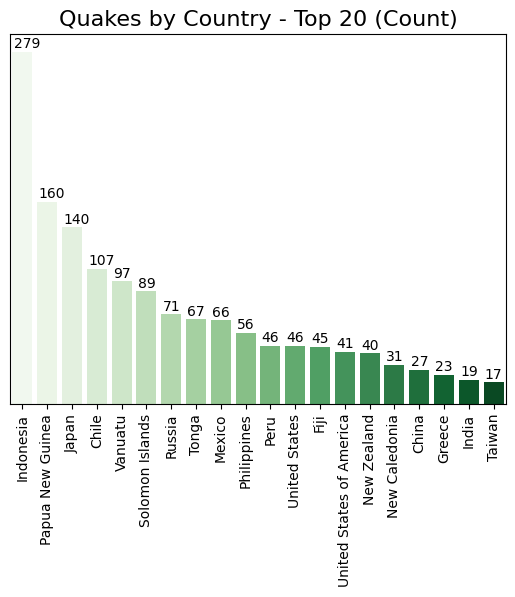

In [24]:
## Now We plot country-wise data with barplots for all the countries and for top 20 countries

plt.title('Quakes by Country - Top 20 (Count)', fontsize=16)
ax = sns.countplot(x=df['country'], palette='Greens', alpha=1, order=df['country'].value_counts().head(20).index)

for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.05, p.get_height()+3))

plt.xticks(rotation=90), plt.xlabel(None), plt.ylabel(None), plt.yticks([])

plt.show();

<ipython-input-25-db0f7938c5a4>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='magnitude', data=df, palette='viridis',order=Morder);


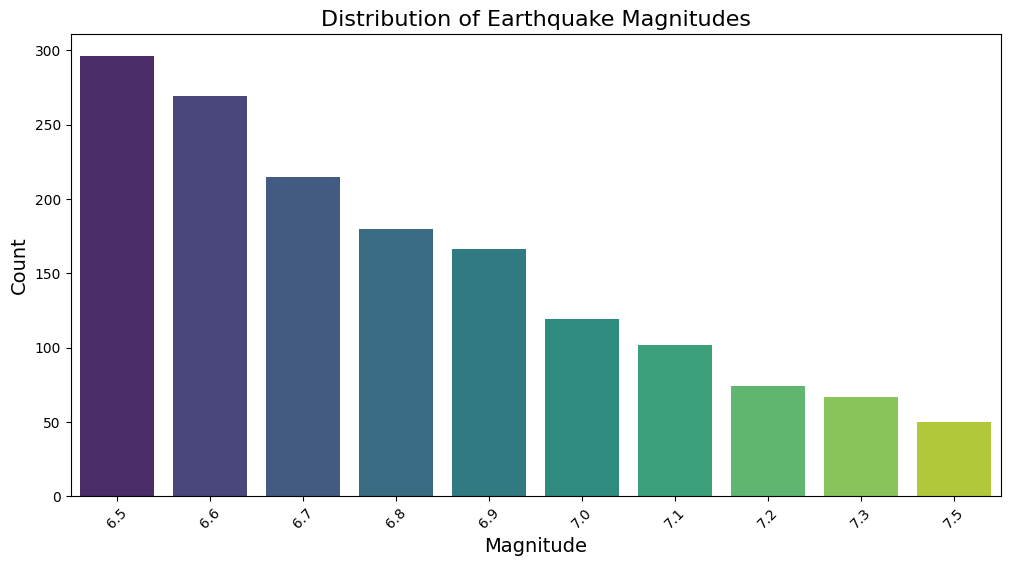

In [25]:
#Selecting top 10 most frequent magnitudes

Morder=df['magnitude'].value_counts().head(10).index
plt.figure(figsize=(12, 6));
sns.countplot(x='magnitude', data=df, palette='viridis',order=Morder);
plt.title('Distribution of Earthquake Magnitudes', fontsize=16);
plt.xlabel('Magnitude', fontsize=14);
plt.ylabel('Count', fontsize=14);
plt.xticks(rotation=45);
plt.show();
#Most earthquakes tend to be around 6.5 to 6.7 on the scale

<ipython-input-26-6679c3e17041>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='country', data=df, order=o, palette='Set2')


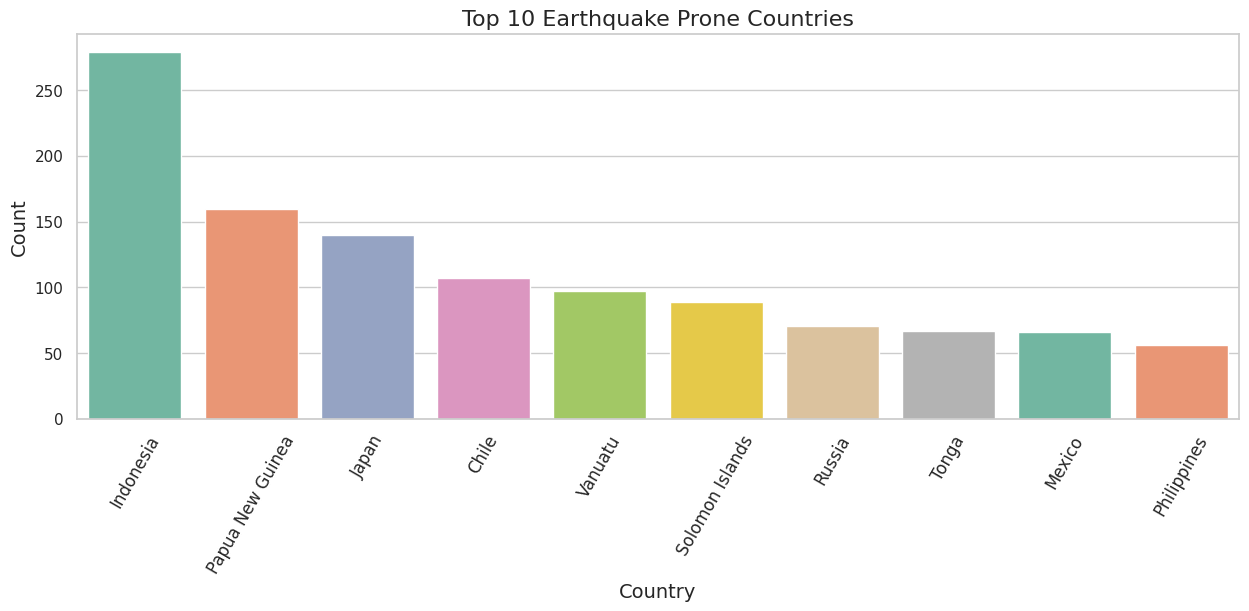

In [26]:
#Selecting top 10 most frequent countries
o = df['country'].value_counts().head(10).index

plt.figure(figsize=(15, 5))

sns.set(style="whitegrid")
sns.countplot(x='country', data=df, order=o, palette='Set2')
plt.xticks(rotation=60, fontsize=12)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Top 10 Earthquake Prone Countries', fontsize=16)
plt.show()

#Indonesia faced the highest number of earthquakes.

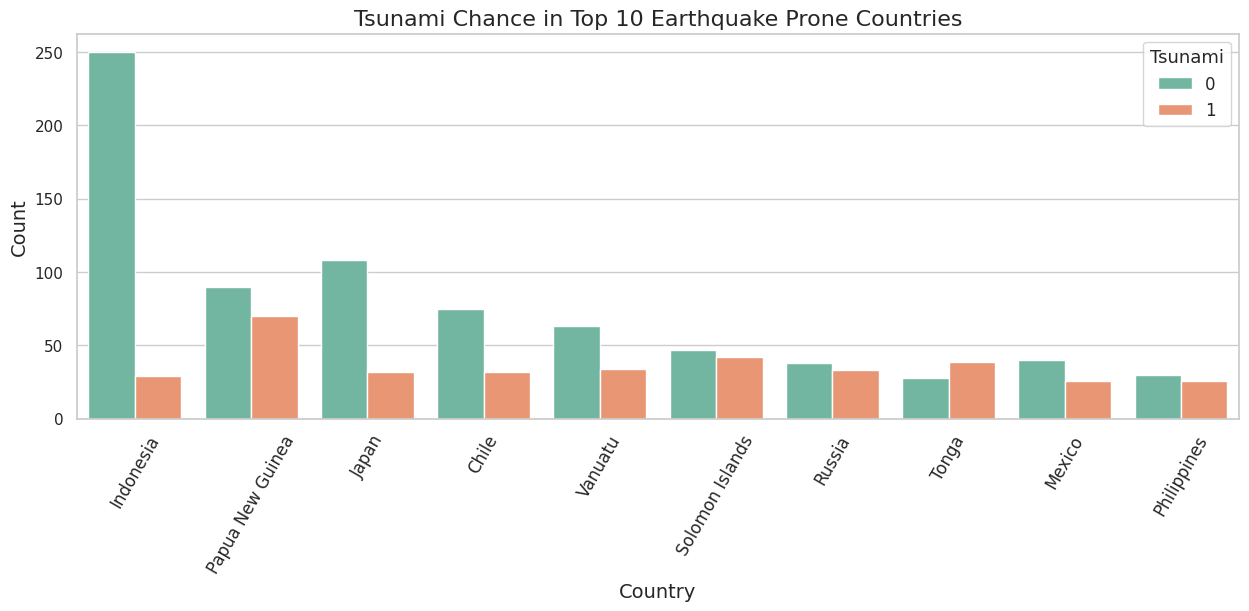

In [27]:
#Tsunami chances in top 10 earthquake prone countries
o = df['country'].value_counts().head(10).index

plt.figure(figsize=(15, 5))

sns.set(style="whitegrid")

sns.countplot(x='country', data=df, order=o, hue='tsunami', palette='Set2')

plt.xticks(rotation=60, fontsize=12)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Tsunami Chance in Top 10 Earthquake Prone Countries', fontsize=16)
plt.legend(title='Tsunami', title_fontsize='13', fontsize='12')
#Indonesia has the highest number of earthquakes worldwide, but Papua New Guinea and Tonga  has a very high risk of tsunamis following an earthquake.

In [28]:
country_count = df.groupby('country')['tsunami'].value_counts().unstack(fill_value=0)
country_count.columns = ['No Tsunami', 'Tsunami']
country_count['Earthquake']=country_count['No Tsunami']+country_count['Tsunami']
country_count['Tsunami Probability']=round((country_count['Tsunami']/country_count['Earthquake'])*100,2)

# Filter out countries with a minimum number of earthquakes
threshold = 5
filtered_country=country_count[country_count['Earthquake']>threshold]
top_10_tsunami_countries=filtered_country.sort_values(by='Tsunami Probability',ascending=False).head(15)
print(top_10_tsunami_countries[['Tsunami Probability', 'Earthquake']])

                 Tsunami Probability  Earthquake
country                                         
Antarctica                    100.00           6
South Georgia                  87.50          16
United Kingdom                 80.00          10
United States                  78.26          46
New Caledonia                  77.42          31
Fiji                           73.33          45
Panama                         71.43          14
New Zealand                    65.00          40
Tonga                          58.21          67
Nicaragua                      57.14          14
Ecuador                        56.25          16
Canada                         50.00          12
Argentina                      50.00           8
Solomon Islands                47.19          89
Russia                         46.48          71


<ipython-input-29-3d43f9d2f0af>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x=top_10_tsunami_countries.index, y=top_10_tsunami_countries['Tsunami Probability'], palette='Set2')


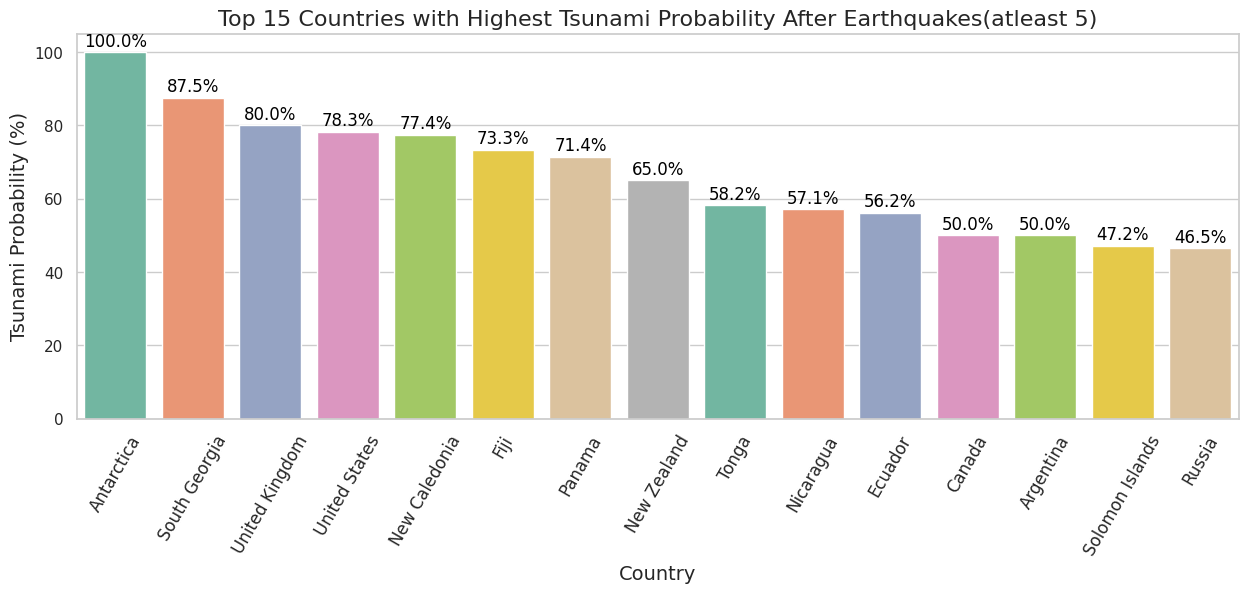

In [29]:
plt.figure(figsize=(15, 5))
ax=sns.barplot(x=top_10_tsunami_countries.index, y=top_10_tsunami_countries['Tsunami Probability'], palette='Set2')
plt.xticks(rotation=60, fontsize=12)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Tsunami Probability (%)', fontsize=14)
plt.title('Top 15 Countries with Highest Tsunami Probability After Earthquakes(atleast 5)', fontsize=16)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()+3),
                ha='center', va='center',fontsize=12, color='black')


In [30]:
pd.crosstab(df['magnitude'], df['tsunami']).head()

tsunami,0,1
magnitude,,
6.5,193,103
6.6,181,88
6.7,150,65
6.8,114,66
6.9,90,76


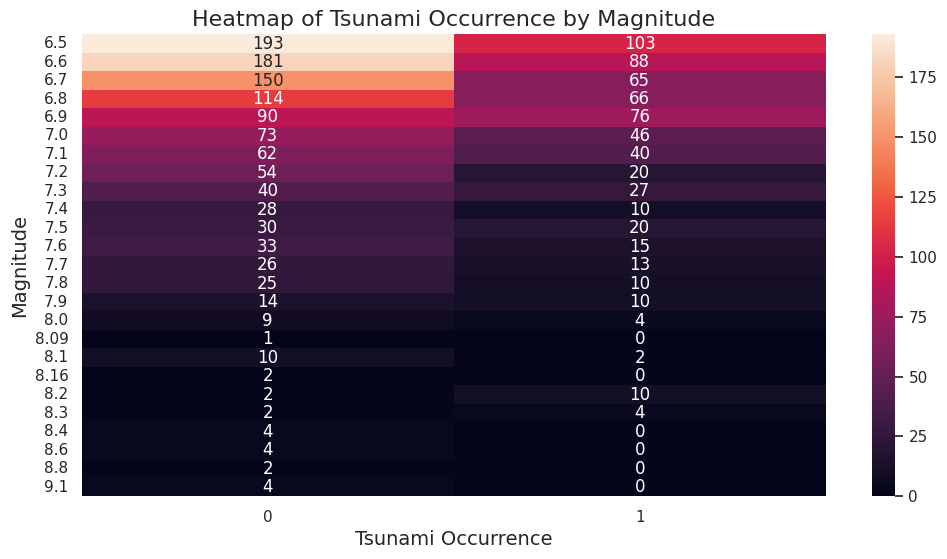

In [31]:
#Heatmap of tsunami occurence by magnitude
heatmap_data = pd.crosstab(df['magnitude'], df['tsunami'])
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f")
plt.xlabel('Tsunami Occurrence', fontsize=14)
plt.ylabel('Magnitude', fontsize=14)
plt.title('Heatmap of Tsunami Occurrence by Magnitude', fontsize=16)
plt.show()

<ipython-input-32-e4442a26595b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='net',data=df,palette='Set2')


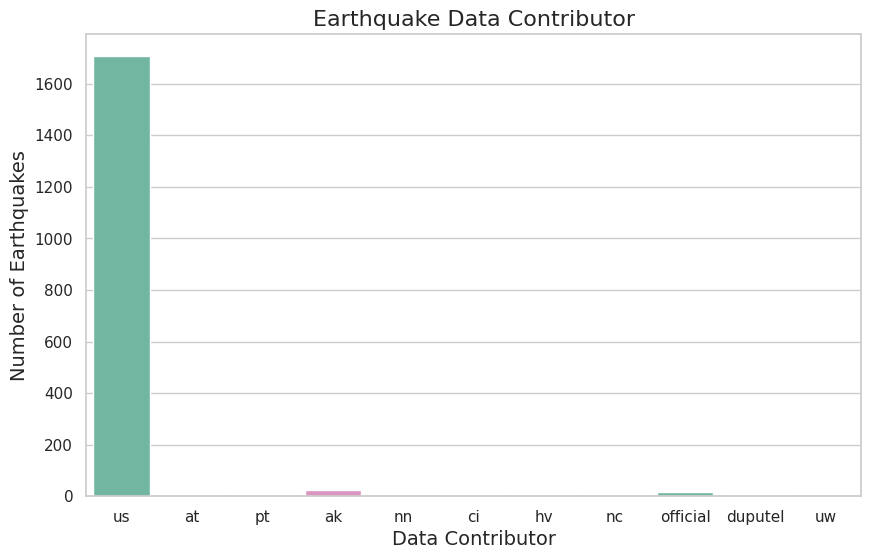

In [32]:
plt.figure(figsize=(10, 6))  # Adjust width and height as needed
sns.countplot(x='net',data=df,palette='Set2')
plt.title('Earthquake Data Contributor', fontsize=16)
plt.xlabel('Data Contributor', fontsize=14)
plt.ylabel('Number of Earthquakes', fontsize=14)
#The US is a major contributor of earthquake data (95%)
plt.show()

In [33]:
df['net'].value_counts()/df.shape[0]*100

,count
net,
us,95.791246
ak,1.346801
official,0.953984
nc,0.336700
duputel,0.336700
at,0.280584
ci,0.280584
pt,0.224467
hv,0.224467


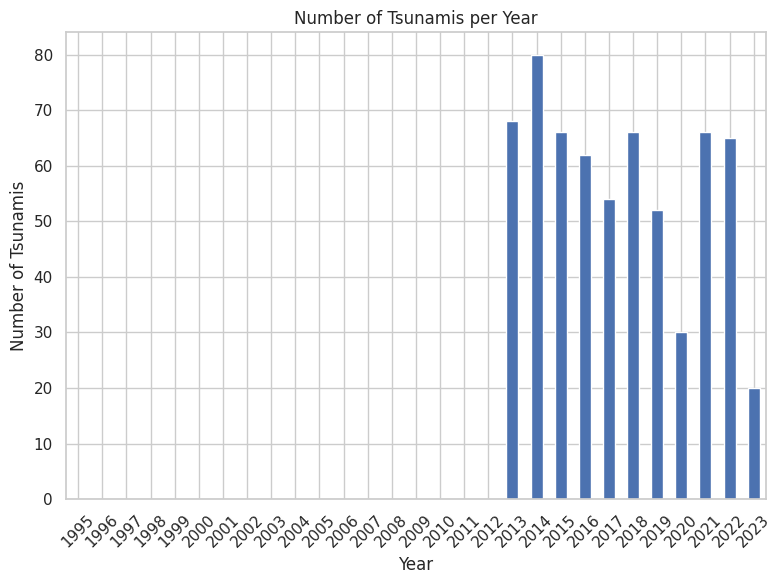

In [34]:
# Group the data by year and count the occurrences of tsunamis
tsunami_by_year = df.groupby('Year')['tsunami'].sum()

# Create the plot
plt.figure(figsize=(8, 6))
tsunami_by_year.plot(kind='bar')
plt.title('Number of Tsunamis per Year')
plt.xlabel('Year')
plt.ylabel('Number of Tsunamis')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-35-cc2c93dca8cc>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Year', data=df, order=top_years, palette='Set2')


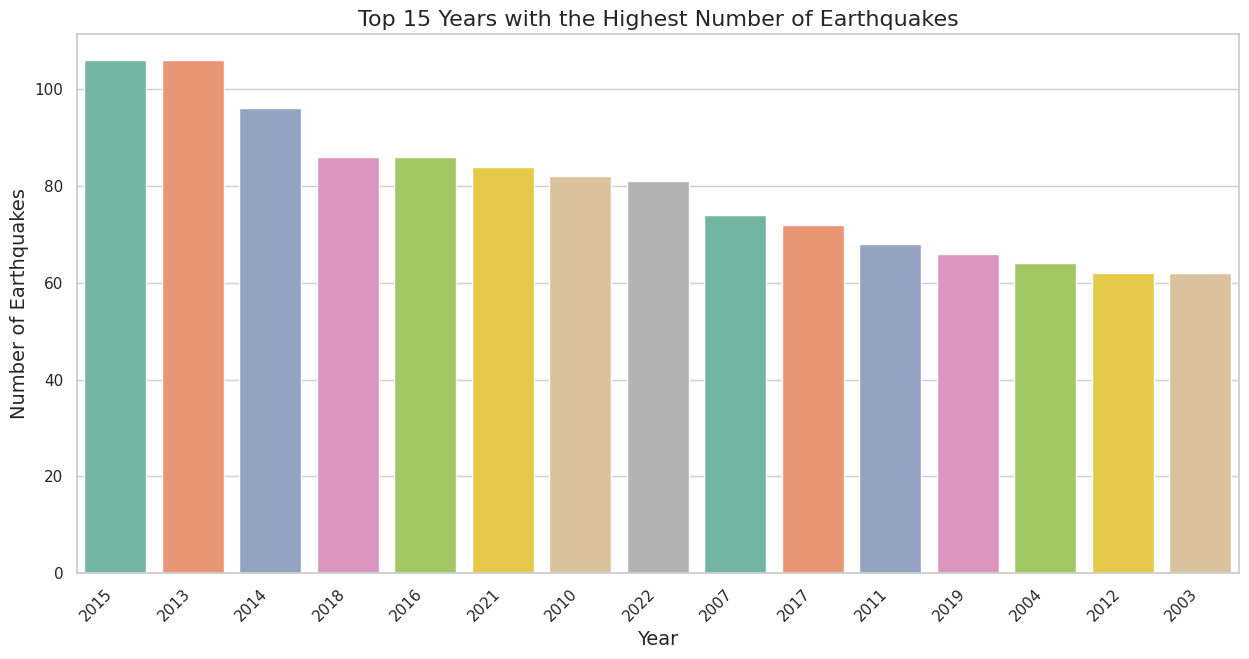

In [35]:
#Top 15 Years with the Highest Number of Earthquakes
plt.figure(figsize=(15, 7))

top_years = df['Year'].value_counts().head(15).index
sns.countplot(x='Year', data=df, order=top_years, palette='Set2')
plt.title('Top 15 Years with the Highest Number of Earthquakes', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Earthquakes', fontsize=14)

plt.xticks(rotation=45, ha='right')

plt.show()
#In 2015 and 2013, the world experienced the highest number of earthquakes.

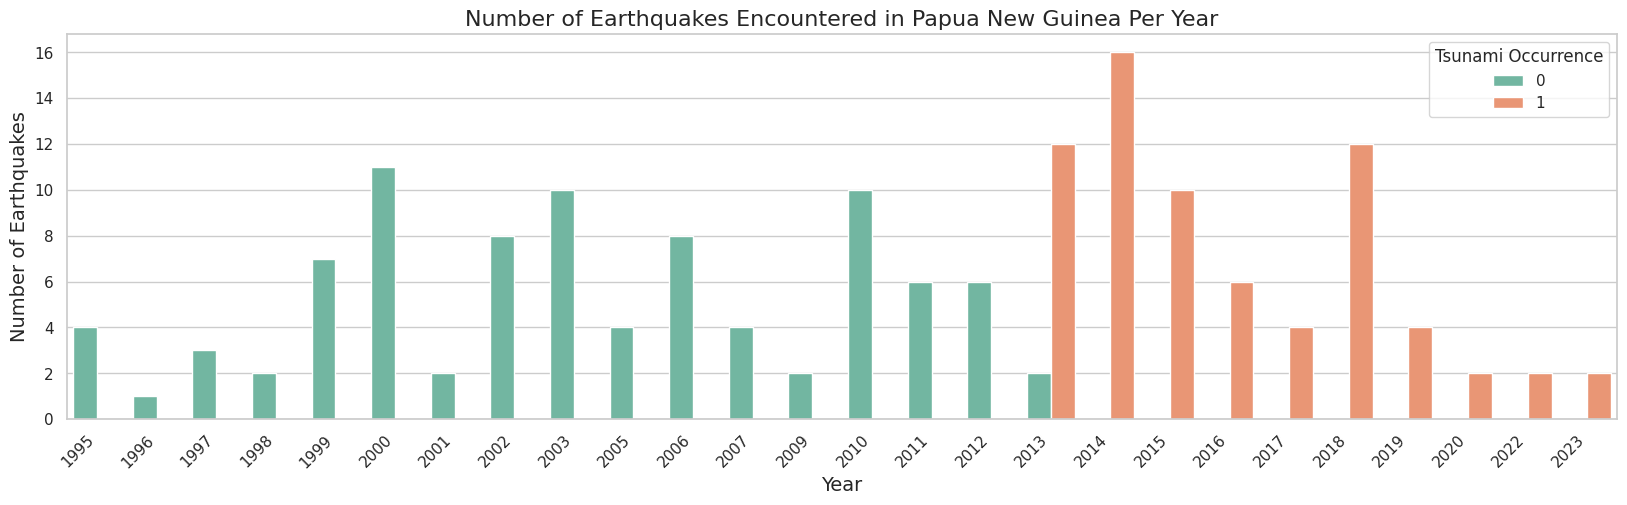

In [36]:
#Earthquakes Encountered in Papua New Guinea Per Year
Papua=df[df['country']=='Papua New Guinea']

plt.figure(figsize=(20, 5))
sns.countplot(x='Year', data=Papua, hue='tsunami', palette='Set2')

plt.title('Number of Earthquakes Encountered in Papua New Guinea Per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Earthquakes', fontsize=14)

plt.xticks(rotation=45, ha='right')

plt.legend(title='Tsunami Occurrence')
#Papua New Guinea experiences at least one earthquake per year but before 2013 Papua New Guinea never experienced tsunami after earthquibck

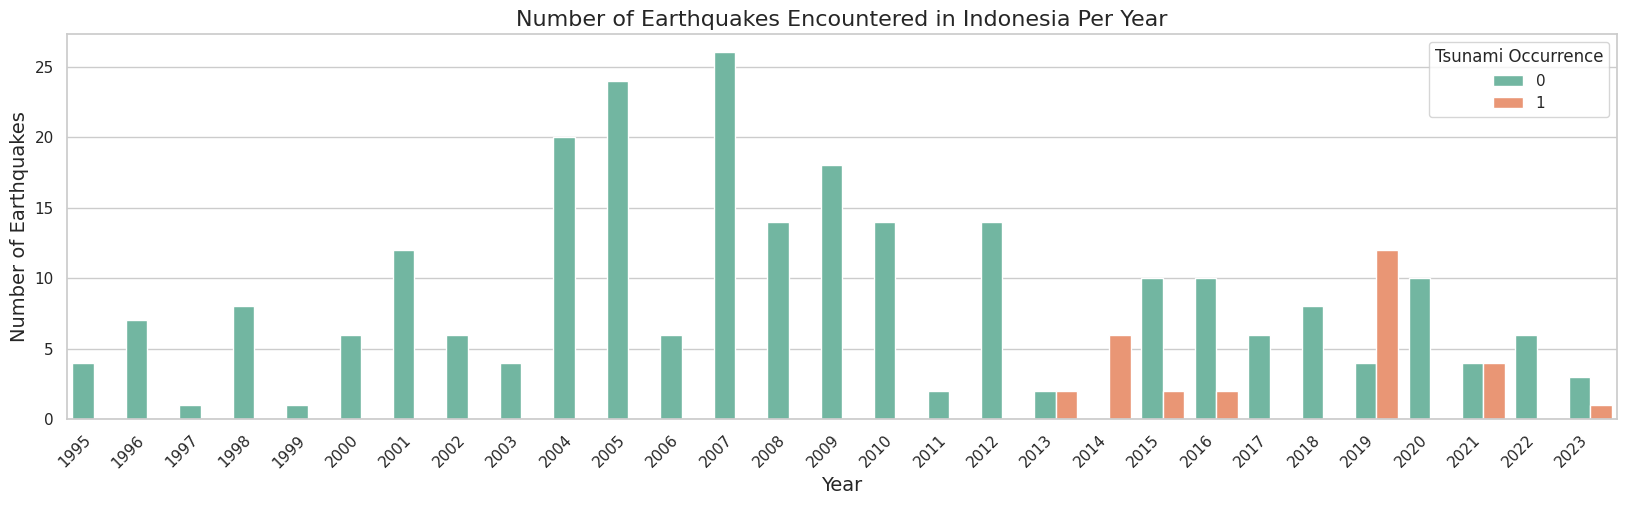

In [37]:
#Earthquakes Encountered in Indonesia Per Year
Indo = df[df['country'] == 'Indonesia']
plt.figure(figsize=(20, 5))
sns.countplot(x='Year', data=Indo, hue='tsunami', palette='Set2')
plt.title('Number of Earthquakes Encountered in Indonesia Per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Earthquakes', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tsunami Occurrence')
plt.show()
#Indonesia encountered 13 earthquic in the year 2007

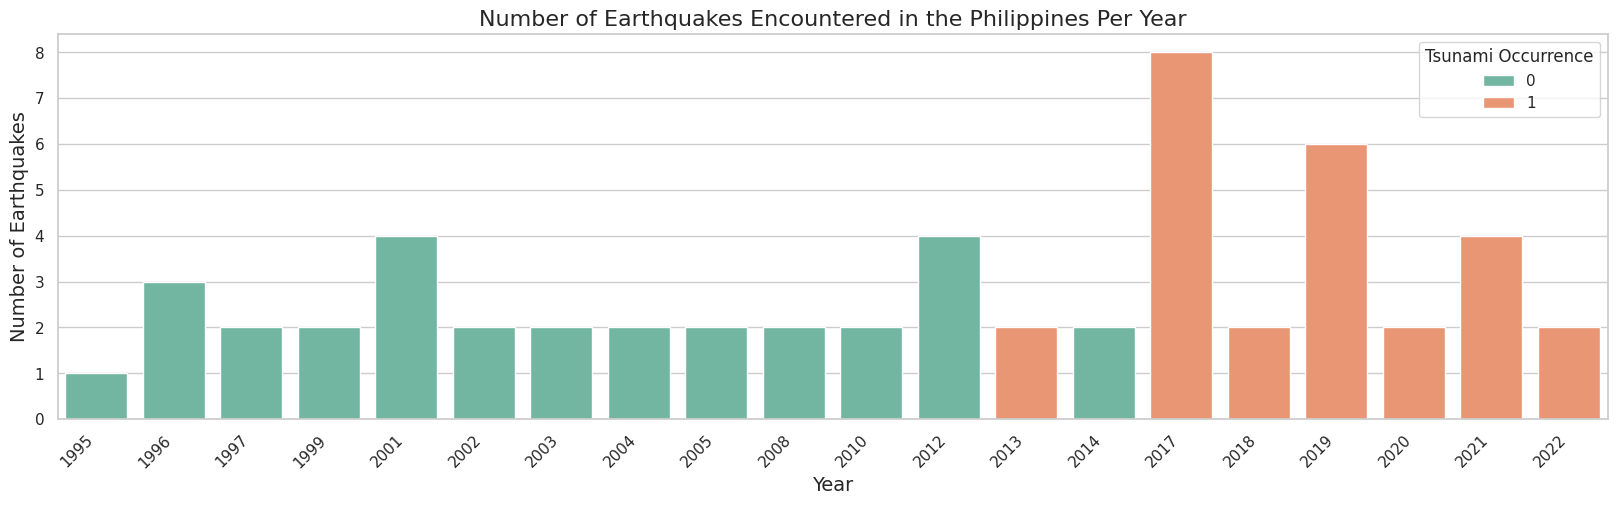

In [38]:
#Earthquakes Encountered in Philippines Per Year
Phi = df[df['country'] == 'Philippines']
plt.figure(figsize=(20, 5))
sns.countplot(x='Year', data=Phi, hue='tsunami', palette='Set2')
plt.title('Number of Earthquakes Encountered in the Philippines Per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Earthquakes', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tsunami Occurrence')
plt.show()
# The Philippines has experienced all of tsunamis in recent years(After 2013) following earthquakes.

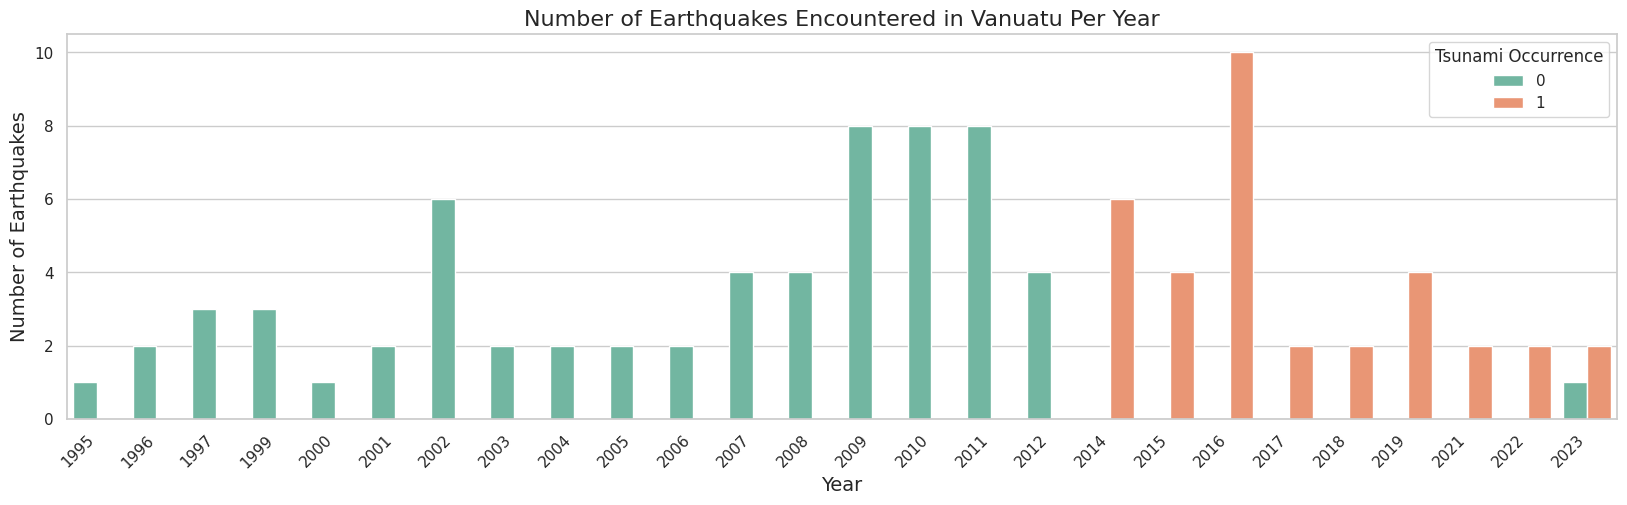

In [39]:
#Earthquake Encoutered in Vanuatu Per Year
Van = df[df['country'] == 'Vanuatu']
plt.figure(figsize=(20, 5))
sns.countplot(x='Year', data=Van, hue='tsunami', palette='Set2')
plt.title('Number of Earthquakes Encountered in Vanuatu Per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Earthquakes', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tsunami Occurrence')
plt.show()

##**Note**:
## After examining the countries most affected by tsunamis, we can conclude that there has been a significant change in climate. Most earthquake-prone countries are facing a greater chance of tsunamis following earthquakes, especially after 2013.

# FEATURE ENGINEERING


In [41]:
df.drop('country',axis=1,inplace=True)#we have latitude and longitude

In [42]:
obj=df.select_dtypes(include=['object'])
obj

,net,magType
0,us,mww
1,us,mww
2,us,mww
3,us,mww
4,us,mww
...,...,...
1777,us,mwb
1778,us,mw
1779,us,mw
1780,us,mw


In [43]:
obj.nunique()

,0
net,11
magType,9


In [44]:
obj.drop('net',axis=1,inplace=True)
df.drop(['net', 'magType'],axis=1,inplace=True)
from sklearn.preprocessing import LabelEncoder
lr=LabelEncoder()
obj_lbl=obj.apply(lr.fit_transform)
df=pd.concat([df,obj_lbl],axis=1)
df.head()

,magnitude,cdi,mmi,tsunami,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,magType
0,7.0,8,7,1,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,8
1,6.9,4,4,0,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,8
2,7.0,3,3,1,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,8
3,7.3,5,5,1,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,8
4,6.6,0,2,1,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,8


<Axes: >

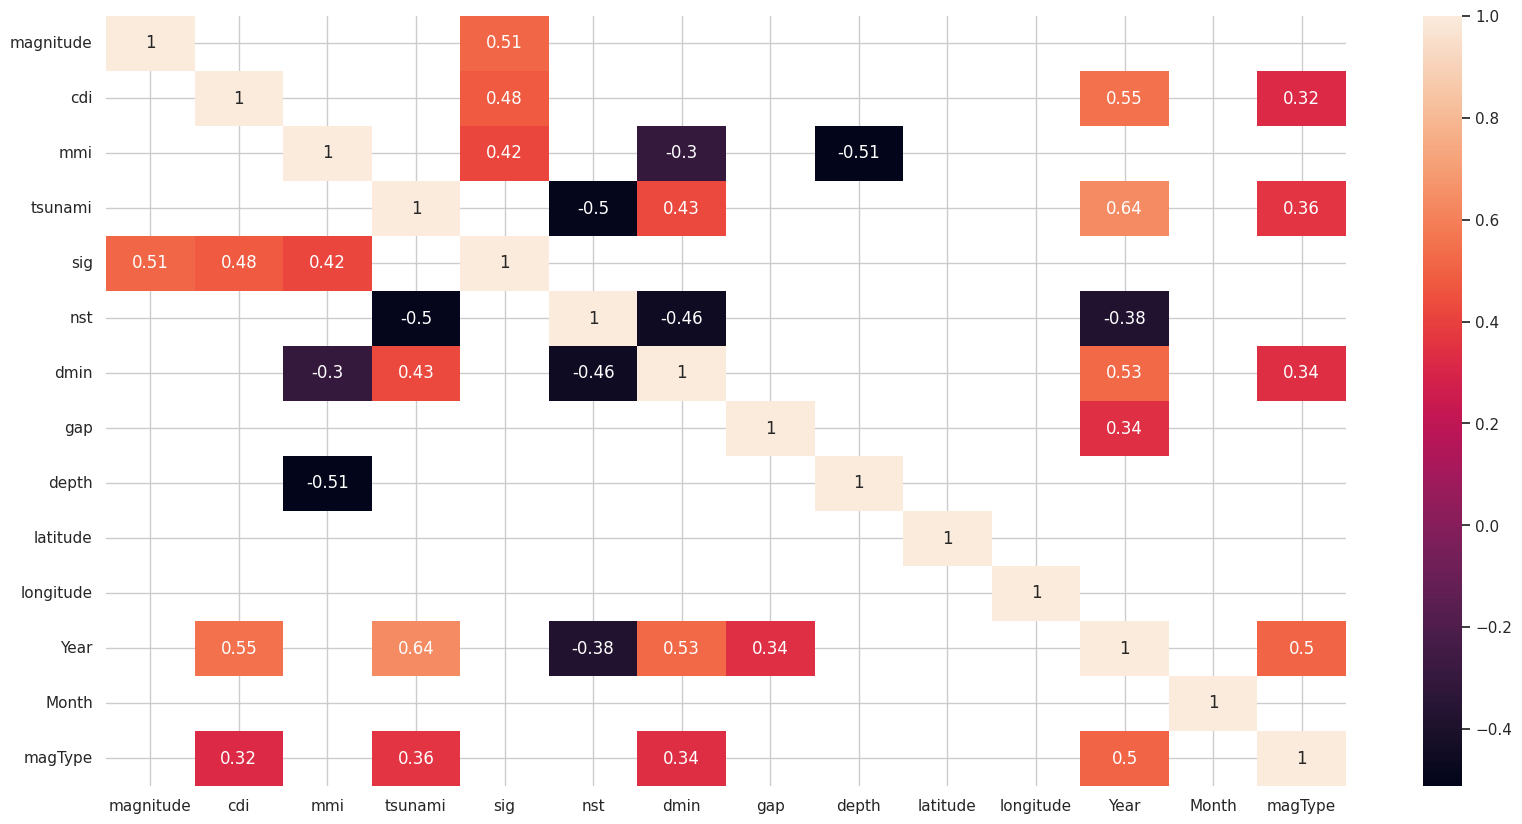

In [45]:
#Correlation matrix
d=df.corr()
d=d[(d>0.3) | (d<-0.3)]
plt.figure(figsize=(20,10))
sns.heatmap(d,annot=True)

# SCALING THE FEATURES

In [46]:
sc = StandardScaler()

x1=df.drop(['cdi'],axis=1)
x2=df.drop(['mmi'],axis=1)
y1=df[['cdi']]
y2=df[['mmi']]
x1_scaled=sc.fit_transform(x1)
x2_scaled=sc.fit_transform(x2)
x1=pd.DataFrame(x1_scaled,columns=x1.columns)
x2=pd.DataFrame(x2_scaled,columns=x2.columns)
x1_train,x1_test,y1_train,y1_test=train_test_split(x1,y1,test_size=0.2, random_state = 4)
x2_train,x2_test,y2_train,y2_test=train_test_split(x2,y2,test_size=0.2, random_state = 4)

In [47]:
sm = SMOTE(random_state = 4)
x1_train,y1_train= sm.fit_resample(x1_train,y1_train)
ros = RandomOverSampler(random_state=4)
x2_train, y2_train = ros.fit_resample(x2_train, y2_train)

In [48]:
y1_train = y1_train.values.ravel()
y2_train = y2_train.values.ravel()
y1_test = y1_test.values.ravel()
y2_test = y2_test.values.ravel()

In [49]:
le = LabelEncoder()
all_labels = np.unique(np.concatenate([y2_train, y2_test]))
le.fit(all_labels)
y2_train = le.transform(y2_train)
y2_test = le.transform(y2_test)

# MODEL BUILDING AND HYPERPARAMETER TUNING

In [50]:
models = {
    "Logistic regression":LogisticRegression(),
    "Decision Tree ":DecisionTreeClassifier(),
    "Random Forest":RandomForestClassifier(),
    "xg":xgb.XGBClassifier()
}

In [51]:
#ESTIMATING CDI
for name,model in models.items():
    model.fit(x1_train,y1_train)
    p = model.predict(x1_test)
    print("Model: " , name)
    print(classification_report(y1_test,p))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model:  Logistic regression
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       120
           1       0.30      0.75      0.43         8
           2       0.09      1.00      0.17         3
           3       0.08      0.16      0.11        19
           4       0.24      0.24      0.24        29
           5       0.53      0.23      0.32        44
           6       0.22      0.11      0.15        37
           7       0.16      0.17      0.16        30
           8       0.41      0.32      0.36        38
           9       0.39      0.45      0.42        29

    accuracy                           0.42       357
   macro avg       0.32      0.41      0.31       357
weighted avg       0.48      0.42      0.43       357

Model:  Decision Tree 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       120
           1       0.50      0.50      0.50         8
           2       1.00    

In [52]:
#Estimating mmi
for name,model in models.items():
    model.fit(x2_train, y2_train)
    p = model.predict(x2_test)
    print("Model: " , name)
    print(classification_report(y2_test,p))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

Model:  Logistic regression
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.50      0.72      0.59        18
           3       0.29      0.43      0.35        37
           4       0.24      0.25      0.25        59
           5       0.40      0.38      0.39        92
           6       0.40      0.20      0.27       103
           7       0.39      0.37      0.38        35
           8       0.18      0.70      0.29        10
           9       0.00      0.00      0.00         1

    accuracy                           0.34       357
   macro avg       0.38      0.45      0.39       357
weighted avg       0.36      0.34      0.34       357

Model:  Decision Tree 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67         2
           2       0.90      1.00      0.95        18
           3       0.92    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model:  xg
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.90      1.00      0.95        18
           3       0.97      0.95      0.96        37
           4       0.88      0.83      0.85        59
           5       0.82      0.89      0.85        92
           6       0.84      0.85      0.85       103
           7       0.90      0.74      0.81        35
           8       0.89      0.80      0.84        10
           9       0.00      0.00      0.00         1

    accuracy                           0.86       357
   macro avg       0.80      0.78      0.79       357
weighted avg       0.86      0.86      0.86       357



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [54]:
# Model:  xg
model=xgb.XGBClassifier()
params = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [5, 7, 9],
}
grid= GridSearchCV(model, params, cv=5)
grid.fit(x1_train,y1_train)
best_params = grid.best_params_
print(best_params)
print(grid.best_score_)

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
0.9595092024539877


In [55]:
p = grid.predict(x1_test)
print(accuracy_score(y1_test,p))

0.896358543417367


## The accuracy of the model is *90%* for estimating CDI

In [56]:
# Model:  xg
model=xgb.XGBClassifier()
params = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
        }
grid= GridSearchCV(model, params, cv=5)
grid.fit(x2_train,y2_train)
print(grid.best_params_)
print(grid.best_score_)

{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300}
0.9492417409960467


In [57]:
p = grid.predict(x2_test)
print(accuracy_score(y2_test,p))

0.8711484593837535


## The accuracy of the model is *87%* for estimating CDI






